torch-gpu

In [1]:
from __future__ import print_function


import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import savgol_filter


from six.moves import xrange

import umap

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torch.optim as optim

import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torchvision.utils import make_grid
from plotting import plot_train_progress_VAE

/Users/danielrzapatas/miniforge3/envs/torch-gpu/lib/python3.8/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/Users/danielrzapatas/miniforge3/envs/torch-gpu/lib/python3.8/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/Users/danielrzapatas/miniforge3/envs/torch-gp

ModuleNotFoundError: No module named 'plotting'

## Vector Quantizer Layer

This layer takes a tensor to be quantized. The channel dimension will be used as the space in which to quantize. All other dimensions will be flattened and will be seen as different examples to quantize.

The output tensor will have the same shape as the input.

As an example for a `BCL` tensor of shape `[363, 64, 30]`, we will first convert it to an `BLC` tensor of shape `[363, 30, 64]` and then reshape it into `[10890, 64]` and all `10890` vectors of size `64`  will be quantized independently. In otherwords, the channels are used as the space in which to quantize. All other dimensions will be flattened and be seen as different examples to quantize, `10890 ` in this case.

In [2]:
class VectorQuantizer(nn.Module):
    def __init__(self, num_embeddings, embedding_dim, commitment_cost):
        super(VectorQuantizer, self).__init__()

        self._embedding_dim = embedding_dim
        self._num_embeddings = num_embeddings

        self._embedding = nn.Embedding(self._num_embeddings, self._embedding_dim).double()
        self._embedding.weight.data.uniform_(-1/self._num_embeddings, 1/self._num_embeddings)
        self._commitment_cost = commitment_cost

    def forward(self, inputs):
        # convert inputs from BCHW -> BHWC
        inputs = inputs.permute(0, 2, 1).contiguous()
        input_shape = inputs.shape

        # Flatten input
        flat_input = inputs.view(-1, self._embedding_dim)

        # Calculate distances
        distances = (torch.sum(flat_input**2, dim=1, keepdim=True)
                    + torch.sum(self._embedding.weight**2, dim=1)
                    - 2 * torch.matmul(flat_input, self._embedding.weight.t()))

        # Encoding
        encoding_indices = torch.argmin(distances, dim=1).unsqueeze(1)
        encodings = torch.zeros(encoding_indices.shape[0], self._num_embeddings, device=inputs.device).double()
        encodings.scatter_(1, encoding_indices, 1)

        # Quantize and unflatten
        quantized = torch.matmul(encodings, self._embedding.weight).view(input_shape)

        # Loss
        e_latent_loss = F.mse_loss(quantized.detach(), inputs)
        q_latent_loss = F.mse_loss(quantized, inputs.detach())
        loss = q_latent_loss + self._commitment_cost * e_latent_loss

        quantized = inputs + (quantized - inputs).detach()
        avg_probs = torch.mean(encodings, dim=0)
        perplexity = torch.exp(-torch.sum(avg_probs * torch.log(avg_probs + 1e-10)))

        # convert quantized from BHWC -> BCHW
        return loss, quantized.permute(0, 2, 1).contiguous(), perplexity, encodings

We will also implement a slightly modified version  which will use exponential moving averages to update the embedding vectors instead of an auxillary loss. This has the advantage that the embedding updates are independent of the choice of optimizer for the encoder, decoder and other parts of the architecture. For most experiments the EMA version trains faster than the non-EMA version.

In [3]:
class VectorQuantizerEMA(nn.Module):
    def __init__(self, num_embeddings, embedding_dim, commitment_cost, decay, epsilon=1e-5):
        super(VectorQuantizerEMA, self).__init__()

        self._embedding_dim = embedding_dim
        self._num_embeddings = num_embeddings

        self._embedding = nn.Embedding(self._num_embeddings, self._embedding_dim).double()
        self._embedding.weight.data.normal_()
        self._commitment_cost = commitment_cost

        self.register_buffer('_ema_cluster_size', torch.zeros(num_embeddings))
        self._ema_w = nn.Parameter(torch.Tensor(num_embeddings, self._embedding_dim)).double()
        self._ema_w.data.normal_()

        self._decay = decay
        self._epsilon = epsilon

    def forward(self, inputs):
        # convert inputs from BCHW -> BHWC
        inputs = inputs.permute(0, 2, 1).contiguous()
        input_shape = inputs.shape

        # Flatten input
        flat_input = inputs.view(-1, self._embedding_dim)

        # Calculate distances
        distances = (torch.sum(flat_input**2, dim=1, keepdim=True)
                    + torch.sum(self._embedding.weight**2, dim=1)
                    - 2 * torch.matmul(flat_input, self._embedding.weight.t()))

        # Encoding
        encoding_indices = torch.argmin(distances, dim=1).unsqueeze(1)
        encodings = torch.zeros(encoding_indices.shape[0], self._num_embeddings, device=inputs.device).double()
        encodings.scatter_(1, encoding_indices, 1)

        # Quantize and unflatten
        quantized = torch.matmul(encodings, self._embedding.weight).view(input_shape)

        # Use EMA to update the embedding vectors
        if self.training:
            self._ema_cluster_size = self._ema_cluster_size * self._decay + \
                                     (1 - self._decay) * torch.sum(encodings, 0)

            # Laplace smoothing of the cluster size
            n = torch.sum(self._ema_cluster_size.data)
            self._ema_cluster_size = (
                (self._ema_cluster_size + self._epsilon)
                / (n + self._num_embeddings * self._epsilon) * n)

            dw = torch.matmul(encodings.t(), flat_input)
            self._ema_w = nn.Parameter(self._ema_w * self._decay + (1 - self._decay) * dw)

            self._embedding.weight = nn.Parameter(self._ema_w / self._ema_cluster_size.unsqueeze(1))

        # Loss
        e_latent_loss = F.mse_loss(quantized.detach(), inputs)
        loss = self._commitment_cost * e_latent_loss

        # Straight Through Estimator
        quantized = inputs + (quantized - inputs).detach()
        avg_probs = torch.mean(encodings, dim=0)
        perplexity = torch.exp(-torch.sum(avg_probs * torch.log(avg_probs + 1e-10)))

        # convert quantized from BHWC -> BCHW
        return loss, quantized.permute(0, 2, 1).contiguous(), perplexity, encodings

## Encoder & Decoder Architecture

The encoder and decoder architecture is based on a ResNet and is implemented below:

In [4]:
class Encoder(nn.Module):
    def __init__(self, in_channels, num_hiddens):
        super(Encoder, self).__init__()

        self._conv_1 = nn.Conv1d(in_channels=in_channels,
                                 out_channels=num_hiddens//2,
                                 kernel_size=4,
                                 stride=2, padding=0).double()
        self._conv_2 = nn.Conv1d(in_channels=num_hiddens//2,
                                 out_channels=num_hiddens,
                                 kernel_size=3,
                                 stride=2, padding=1).double()
        self._conv_3 = nn.Conv1d(in_channels=num_hiddens,
                                 out_channels=num_hiddens,
                                 kernel_size=3,
                                 stride=2, padding=0).double()

    def forward(self, inputs):
        inputs = inputs.unsqueeze(1)
        x = self._conv_1(inputs)
        x = F.relu(x)

        x = self._conv_2(x)
        x = F.relu(x)

        x = self._conv_3(x)
        return x

In [5]:
class Decoder(nn.Module):
    def __init__(self, in_channels, num_hiddens, embedding_dim):
        super(Decoder, self).__init__()

        self._conv_trans_1 = nn.ConvTranspose1d(in_channels=embedding_dim,
                                                        out_channels=num_hiddens,
                                                        kernel_size=1,
                                                        stride=1, padding=0, 
                                                        output_padding=0).double()

        self._conv_trans_2 = nn.ConvTranspose1d(in_channels=num_hiddens,
                                                        out_channels=num_hiddens,
                                                        kernel_size=3,
                                                        stride=2, padding=0, 
                                                        output_padding=1).double() 
        self._conv_trans_3 = nn.ConvTranspose1d(in_channels=num_hiddens,
                                                        out_channels=num_hiddens//2,
                                                        kernel_size=3,
                                                        stride=2, padding=1, 
                                                        output_padding=1).double()
        self._conv_trans_4 = nn.ConvTranspose1d(in_channels=num_hiddens//2,
                                                        out_channels=in_channels,
                                                        kernel_size=4,
                                                        stride=2, padding=0).double()

    def forward(self, inputs):
        
        x = self._conv_trans_1(inputs)
        x = F.relu(x)
        x = self._conv_trans_2(x)
        x = F.relu(x)
        x = self._conv_trans_3(x)
        x = F.relu(x)
        x = self._conv_trans_4(x)

        return x.squeeze(1)

In [6]:
class VQ_VAE(nn.Module):
    def __init__(self, num_hiddens,
                 num_embeddings, embedding_dim, commitment_cost, decay=0):
        super(VQ_VAE, self).__init__()

        self._encoder = Encoder(1, num_hiddens)
        self._pre_vq_conv = nn.Conv1d(in_channels=num_hiddens,
                                      out_channels=embedding_dim,
                                      kernel_size=1,
                                      stride=1, padding=0).double()
        if decay > 0.0:
            self._vq_vae = VectorQuantizerEMA(num_embeddings, embedding_dim,
                                              commitment_cost, decay)
        else:
            self._vq_vae = VectorQuantizer(num_embeddings, embedding_dim,
                                           commitment_cost)
        self._decoder = Decoder(1, num_hiddens, embedding_dim)
                                

    def forward(self, x):
        # print(f'Input Shape {x.shape}, Expected: [363, 250]')
        z = self._encoder(x)
        # print(f'Encoder output shape: {z.shape}, Expected: [363, 200, 30]')
        z = self._pre_vq_conv(z)
        # print(f'Pre VQ Conv output shape: {z.shape}, Expected: [363, 64, 30]')
        loss, quantized, perplexity, _ = self._vq_vae(z)
        # print(f'Quantized shape: {quantized.shape}, Expected: [363, 64, 30]')
        x_recon = self._decoder(quantized)
        # print(f'Decoder output shape: {x_recon.shape}, Expected: [363, 250]')

        return loss, x_recon, perplexity

In [7]:
def train_vq_vae(vq_vae, data, epochs=10, learning_rate=1e-3):
    optimizer = optim.Adam(vq_vae.parameters(), lr=learning_rate, amsgrad=False)
    train_res_recon_error = []
    train_res_perplexity = []
    loss_total_to_plot = []

    for epoch in range(epochs):
        for i, batch in enumerate(data):
            batch = np.transpose(batch) 
            batch = batch[:, np.random.permutation(batch.shape[1])]
            x = torch.from_numpy(batch)
            x = x.to(device)
            optimizer.zero_grad()
            vq_loss, x_recon, perplexity = vq_vae(x)

            recon_error = F.mse_loss(x_recon, x)
            loss = recon_error + vq_loss
            loss.backward()

            optimizer.step()

            train_res_recon_error.append(recon_error.item())
            train_res_perplexity.append(perplexity.item())
            loss_total_to_plot.append(loss.item())
            print('Epoch %s/%s, batch %s ,Loss=%s, recon_error=%.3f, perplexity: %.3f' % (epoch+1, epochs,i, loss.item(), recon_error.item(), perplexity.item()))
    plot_train_progress_VAE(loss_total_to_plot, train_res_recon_error, train_res_perplexity, iters_per_point=1, y_lims=[1., 1., None])
    return vq_vae, train_res_recon_error, train_res_perplexity, loss_total_to_plot
    


## Load Data 

In [8]:
# Load data
data = np.load('master_data/data.npy')
train_batches = data.shape[0] # N hereafter. Number of training images in database.
length = data.shape[1] 
stocks = data.shape[2]
print('Number of training batches: ', train_batches)
print('Length of each batch: ', length)
print('Number of stocks: ', stocks)
data.shape

Number of training batches:  189
Length of each batch:  250
Number of stocks:  363


(189, 250, 363)

In [9]:
batch_size = 362
num_training_updates = 15000

num_hiddens = 200


embedding_dim = 64
num_embeddings = 512

commitment_cost = 0.25

decay = 0

learning_rate = 1e-3

In [25]:
device = torch.device(torch.device("mps") if torch.backends.mps.is_available() else "cpu")
print(device)

mps


In [27]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


## VectorQuantizer

In [28]:
vq_vae = VQ_VAE(num_hiddens,
              num_embeddings, embedding_dim,
              commitment_cost, decay).to(device)

In [29]:
data[0].shape

(250, 363)

Epoch 1/5, batch 0 ,Loss=0.00865769089148711, recon_error=0.006, perplexity: 1.587
Epoch 1/5, batch 1 ,Loss=0.004401681917580981, recon_error=0.001, perplexity: 1.000
Epoch 1/5, batch 2 ,Loss=0.004641894502292283, recon_error=0.003, perplexity: 1.000
Epoch 1/5, batch 3 ,Loss=0.004032871802831666, recon_error=0.003, perplexity: 1.010
Epoch 1/5, batch 4 ,Loss=0.0031176609601555206, recon_error=0.002, perplexity: 1.000
Epoch 1/5, batch 5 ,Loss=0.0026523694427191386, recon_error=0.001, perplexity: 1.000
Epoch 1/5, batch 6 ,Loss=0.0024233698334602946, recon_error=0.001, perplexity: 1.000
Epoch 1/5, batch 7 ,Loss=0.0021517106112506836, recon_error=0.001, perplexity: 1.000
Epoch 1/5, batch 8 ,Loss=0.0020310096239347973, recon_error=0.002, perplexity: 1.155
Epoch 1/5, batch 9 ,Loss=0.0018015913715785238, recon_error=0.001, perplexity: 1.000
Epoch 1/5, batch 10 ,Loss=0.0016428254111481152, recon_error=0.001, perplexity: 1.000
Epoch 1/5, batch 11 ,Loss=0.001389829549659963, recon_error=0.001, pe

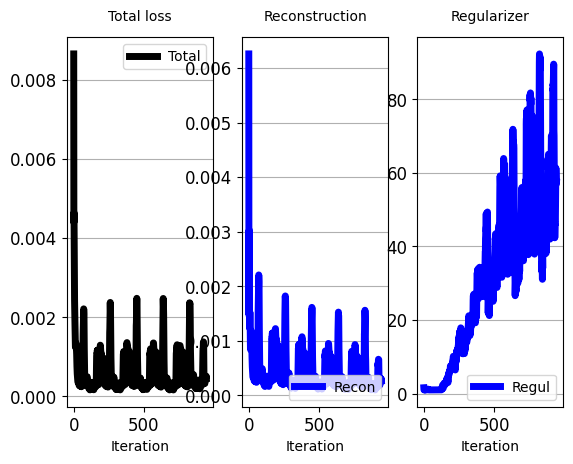

In [30]:
vq_vae, train_res_recon_error, train_res_perplexity, loss_total_to_plot = train_vq_vae(vq_vae, data, epochs=5, learning_rate=1e-3)

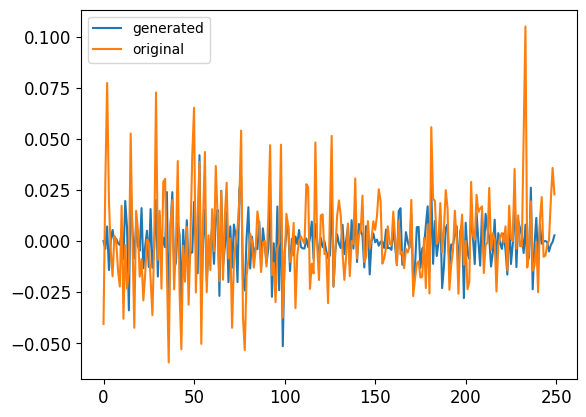

In [31]:
batch= data[0]
batch= np.transpose(batch)
x = torch.from_numpy(batch)
_, x_hat, _ = vq_vae(x)
x_hat = x_hat.to('cpu').detach().numpy()
plt.plot(x_hat[0, :], label='generated')
plt.plot(batch[0, :], label='original')
plt.legend()
plt.show()

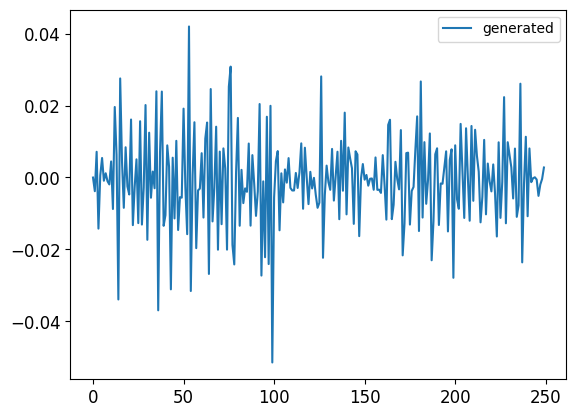

In [32]:
plt.plot(x_hat[0, :], label='generated')
plt.legend()
plt.show()

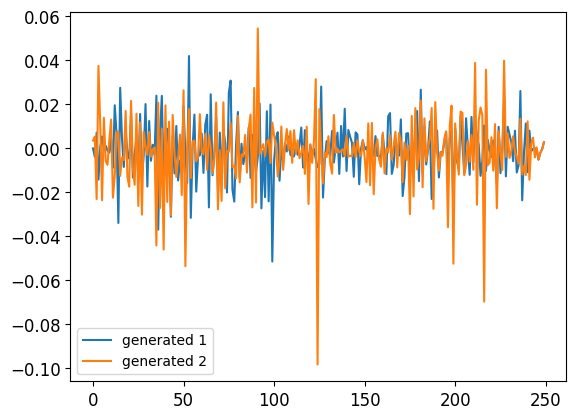

In [33]:
plt.plot(x_hat[0, :], label='generated 1')
plt.plot(x_hat[40, :], label='generated 2')
plt.legend()
plt.show()

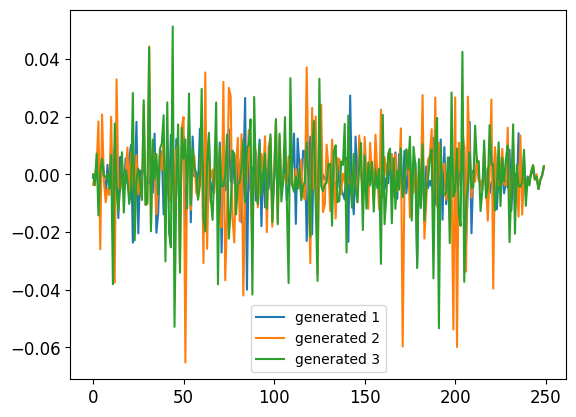

In [34]:
plt.plot(x_hat[20, :], label='generated 1')
plt.plot(x_hat[10, :], label='generated 2')
plt.plot(x_hat[100, :], label='generated 3')
# plt.plot(x_hat[0, :], label='generated 5')
# plt.plot(x_hat[40, :], label='generated 6')
plt.legend()
plt.show()

## View Embedding

In [36]:
proj = umap.UMAP(n_neighbors=3,
                 min_dist=0.1,
                 metric='cosine').fit_transform(vq_vae._vq_vae._embedding.weight.data.cpu())

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


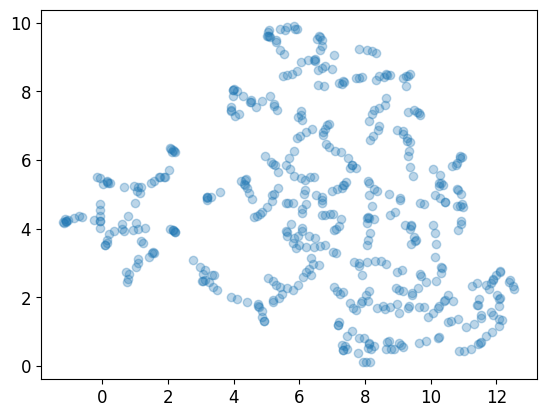

In [37]:
plt.scatter(proj[:,0], proj[:,1], alpha=0.3)

## VectorQuantizerEMA 


In [38]:
vq_vae_ema = VQ_VAE(num_hiddens,
              num_embeddings, embedding_dim,
              commitment_cost, decay=0.99).to(device)

Epoch 1/5, batch 0 ,Loss=0.31835063307358263, recon_error=0.183, perplexity: 1.000
Epoch 1/5, batch 1 ,Loss=0.1466564143826016, recon_error=0.146, perplexity: 1.000
Epoch 1/5, batch 2 ,Loss=0.08999151264007837, recon_error=0.089, perplexity: 1.000
Epoch 1/5, batch 3 ,Loss=0.04435731202618304, recon_error=0.041, perplexity: 1.000
Epoch 1/5, batch 4 ,Loss=0.017521244178644486, recon_error=0.011, perplexity: 1.000
Epoch 1/5, batch 5 ,Loss=0.01778654796488241, recon_error=0.007, perplexity: 1.000
Epoch 1/5, batch 6 ,Loss=0.03622912366889252, recon_error=0.029, perplexity: 1.000
Epoch 1/5, batch 7 ,Loss=0.04531774873290148, recon_error=0.043, perplexity: 1.000
Epoch 1/5, batch 8 ,Loss=0.035409777454398134, recon_error=0.035, perplexity: 1.000
Epoch 1/5, batch 9 ,Loss=0.019978748504087502, recon_error=0.019, perplexity: 1.000
Epoch 1/5, batch 10 ,Loss=0.009518573436737338, recon_error=0.007, perplexity: 1.000
Epoch 1/5, batch 11 ,Loss=0.0057594650191057275, recon_error=0.003, perplexity: 1.0

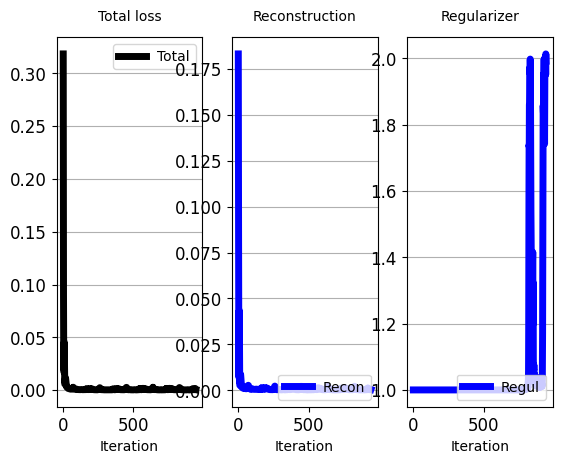

In [41]:
vq_vae_ema, train_res_recon_error, train_res_perplexity, loss_total_to_plot = train_vq_vae(vq_vae_ema, data, epochs=5, learning_rate=1e-3)

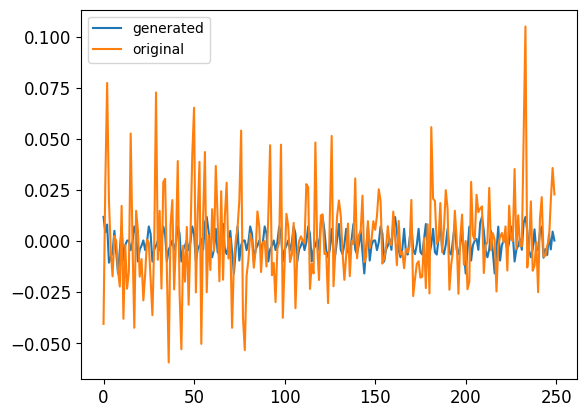

In [42]:
batch= data[0]
batch= np.transpose(batch)
x = torch.from_numpy(batch)
_, x_hat, _ = vq_vae_ema(x)
x_hat = x_hat.to('cpu').detach().numpy()
plt.plot(x_hat[0, :], label='generated')
plt.plot(batch[0, :], label='original')
plt.legend()
plt.show()

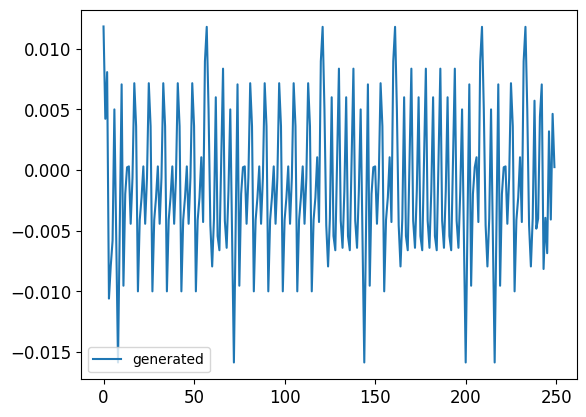

In [43]:
plt.plot(x_hat[0, :], label='generated')
plt.legend()
plt.show()

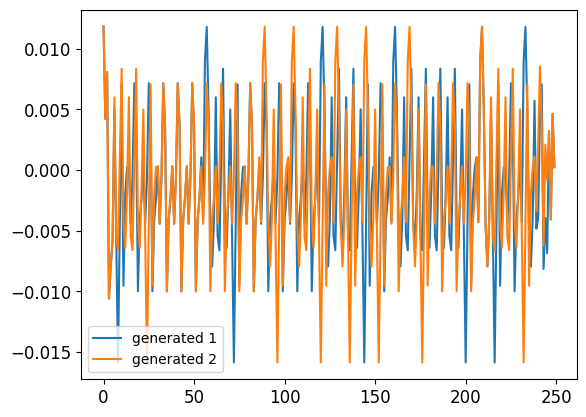

In [44]:
plt.plot(x_hat[0, :], label='generated 1')
plt.plot(x_hat[40, :], label='generated 2')
plt.legend()
plt.show()

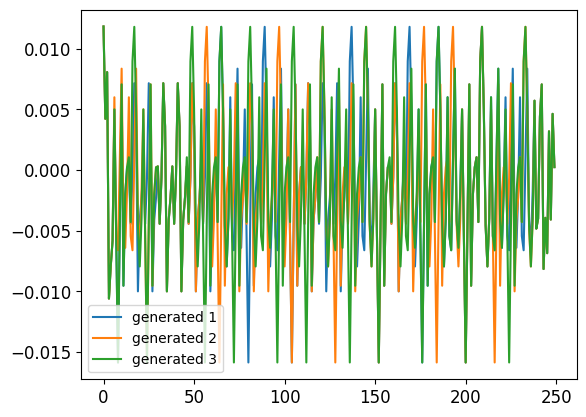

In [45]:
plt.plot(x_hat[20, :], label='generated 1')
plt.plot(x_hat[10, :], label='generated 2')
plt.plot(x_hat[100, :], label='generated 3')
# plt.plot(x_hat[0, :], label='generated 5')
# plt.plot(x_hat[40, :], label='generated 6')
plt.legend()
plt.show()

In [48]:
proj = umap.UMAP(n_neighbors=3,
                 min_dist=0.1,
                 metric='cosine').fit_transform(vq_vae_ema._vq_vae._embedding.weight.data.cpu())

In [50]:
proj.shape

(512, 2)

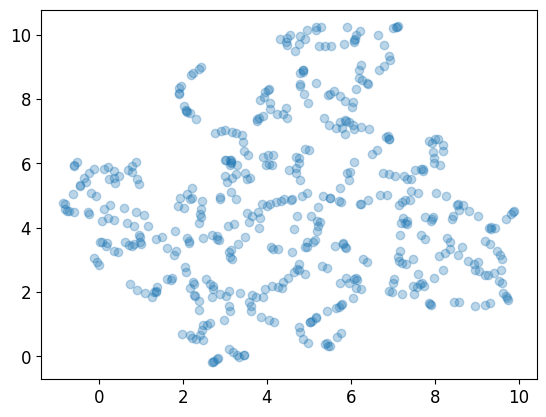

In [49]:
plt.scatter(proj[:,0], proj[:,1], alpha=0.3)